In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [155]:
# 设置matplotlib中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [156]:
def load_sale_data(file_path='filtered_sale_data.parquet'):
    if os.path.exists(file_path):
        print(f"正在加载销售数据: {file_path}")
        sale_df = pd.read_parquet(file_path)
        print(f"销售数据形状: {sale_df.shape}")
        return sale_df
    else:
        print(f"错误: 未找到销售数据文件 {file_path}")
        return None

# 加载租赁数据
def load_rental_data(file_path='filtered_rental_data.parquet'):
    if os.path.exists(file_path):
        print(f"正在加载租赁数据: {file_path}")
        rental_df = pd.read_parquet(file_path)
        print(f"租赁数据形状: {rental_df.shape}")
        return rental_df
    else:
        print(f"错误: 未找到租赁数据文件 {file_path}")
        return None


In [157]:
# 数据描述函数
def describe_data(df, data_type):
    print(f"\n" + "="*60)
    print(f"{data_type}数据描述")
    print("="*60)
    
    # 基本信息
    print(f"数据形状: {df.shape}")
    print(f"\n列信息:")
    print(df.info())
    
    # 数值列统计
    print(f"\n数值列统计:")
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    print(df[numeric_cols].describe())
    
    # Block分布
    if 'Block' in df.columns:
        print(f"\nBlock分布:")
        block_counts = df['Block'].value_counts()
        print(block_counts)
    
    return df[numeric_cols].describe()

In [158]:
# 离群值检测函数（使用IQR方法）
def detect_outliers(df, value_column):
    # 将值列转换为数值类型
    df[value_column] = pd.to_numeric(df[value_column], errors='coerce')
    
    # 移除无法转换为数值的行
    df = df.dropna(subset=[value_column])
    
    # 计算IQR
    Q1 = df[value_column].quantile(0.25)
    Q3 = df[value_column].quantile(0.75)
    IQR = Q3 - Q1
    
    # 定义离群值的阈值
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 统计离群值数量
    outliers_count = df[(df[value_column] < lower_bound) | (df[value_column] > upper_bound)].shape[0]
    total_count = df.shape[0]
    
    print(f"检测到的{value_column}离群值数量: {outliers_count}/{total_count}")
    print(f"离群值比例: {(outliers_count/total_count)*100:.2f}%")
    print(f"{value_column}范围: {lower_bound:.2f} - {upper_bound:.2f}")
    
    # 识别离群值行
    outliers = df[(df[value_column] < lower_bound) | (df[value_column] > upper_bound)]
    
    return outliers, lower_bound, upper_bound

# 移除离群值函数
def remove_outliers(df, value_column):
    outliers, lower_bound, upper_bound = detect_outliers(df, value_column)
    
    # 移除离群值
    filtered_df = df[(df[value_column] >= lower_bound) & (df[value_column] <= upper_bound)]
    
    # 计算统计信息
    stats = {
        '原始数据量': df.shape[0],
        '过滤后数据量': filtered_df.shape[0],
        '移除的数据量': outliers.shape[0],
        '最小值': filtered_df[value_column].min(),
        '最大值': filtered_df[value_column].max(),
        '平均值': filtered_df[value_column].mean(),
        '中位数': filtered_df[value_column].median()
    }
    
    return filtered_df, stats

In [159]:
# 准备数据用于模型训练
def prepare_data(df, target_column):
    # 检查是否包含必要的列
    required_columns = ['Area', 'Block']
    for col in required_columns:
        if col not in df.columns:
            print(f"错误: 数据中缺少必要的列 '{col}'")
            return None, None
    
    # 转换数值列
    df['Area'] = pd.to_numeric(df['Area'], errors='coerce')
    
    # 删除缺失值
    df = df.dropna(subset=['Area'])
    
    # 定义特征和目标变量
    X = df[['Area', 'Block']]
    y = df[target_column]
    
    return X, y

# 创建并训练线性模型
def create_and_train_linear_model(X, y):
    # 创建预处理步骤 - 对Block进行one-hot编码
    preprocessor = ColumnTransformer(
        transformers=[
            ('block_encoder', OneHotEncoder(handle_unknown='ignore'), ['Block'])
        ],
        remainder='passthrough'  # 保留Area列
    )
    
    # 创建Pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    # 训练模型
    model.fit(X, y)
    
    return model

# 创建并训练优化模型（添加非线性特征和交互项）
def create_and_train_nonlinear_interaction_model(X, y, degree=2):
    # 创建预处理步骤
    preprocessor = ColumnTransformer(
        transformers=[
            # 对Block进行独热编码
            ('block_encoder', OneHotEncoder(handle_unknown='ignore'), ['Block']),
            # 对Area添加多项式特征
            ('poly_features', PolynomialFeatures(degree=degree, include_bias=False), ['Area'])
        ],
        remainder='drop'
    )
    
    # 创建Pipeline
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_interaction', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
        ('regressor', LinearRegression())
    ])
    
    # 训练模型
    model.fit(X, y)
    
    return model

# 评估模型性能
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"\n{model_name} 模型评估:")
    print(f"R² 分数: {r2:.4f}")
    print(f"均方根误差 (RMSE): {rmse:.2f}")
    
    return y_pred, r2

In [160]:
# 计算price to rent ratio
def calculate_price_to_rent_ratio(sale, rent):
    # 确保两个预测数组长度相同
    if len(sale) != len(rent):
        print("错误: 销售和租赁数据长度不匹配")
        return None
    
    # 计算price to rent ratio
    # 注意：这里假设销售价格是每平方米的价格，租金也是每平方米的价格
    # 为了避免除以零的情况，将零租金替换为很小的数
    rent = np.where(rent == 0, 1e-6, rent)
    
    # 计算price to rent ratio (房价/年租金)
    price_to_rent_ratios = sale / rent
    
    return price_to_rent_ratios

# 计算每平方米价格和租金
def calculate_area_ratios(df, data_type):
    # 深拷贝数据框以避免修改原始数据
    df_copy = df.copy()
    
    # 确保数值列转换为数值类型
    if data_type == 'sale':
        # 确保Price和Area列是数值类型
        df_copy['Price'] = pd.to_numeric(df_copy['Price'], errors='coerce')
        df_copy['Area'] = pd.to_numeric(df_copy['Area'], errors='coerce')
        
        # 删除无法转换的行
        df_copy = df_copy.dropna(subset=['Price', 'Area'])
        
        # 计算价格/面积比
        df_copy['Price_Per_Area'] = df_copy['Price'] / df_copy['Area']
        ratio_column = 'Price_Per_Area'
        ratio_name = '价格/面积比'

        
    elif data_type == 'rent':
        # 确保Rent和Area列是数值类型
        df_copy['Rent'] = pd.to_numeric(df_copy['Rent'], errors='coerce')
        df_copy['Area'] = pd.to_numeric(df_copy['Area'], errors='coerce')
        
        # 删除无法转换的行
        df_copy = df_copy.dropna(subset=['Rent', 'Area'])
        
        # 计算租金/面积比
        df_copy['Rent_Per_Area'] = df_copy['Rent'] / df_copy['Area']
        ratio_column = 'Rent_Per_Area'
        ratio_name = '租金/面积比'
    
    # 计算整体中位数
    overall_median = df_copy[ratio_column].median()
    print(f"\n整体{ratio_name}中位数: {overall_median:.2f} 元/平方米")
    
    # 按Block计算中位数
    if 'Block' in df_copy.columns:
        block_medians = df_copy.groupby('Block')[ratio_column].median().sort_values(ascending=False)
        print(f"\n各Block{ratio_name}中位数:")
        for block, median in block_medians.items():
            print(f"{block}: {median:.2f} 元/平方米")
    
    return df_copy, ratio_column, block_medians

In [161]:
# 绘制R²分数比较图
def plot_r2_comparison(linear_r2, nonlinear_r2, model_names):
    plt.figure(figsize=(10, 6))
    width = 0.35
    x = np.arange(len(model_names))
    
    plt.bar(x - width/2, linear_r2, width, label='线性模型')
    plt.bar(x + width/2, nonlinear_r2, width, label='优化模型')
    
    plt.xlabel('模型')
    plt.ylabel('R方分数')
    plt.title('线性模型与优化模型的R方分数比较')
    plt.xticks(x, model_names)
    plt.legend()
    plt.tight_layout()
    
    # 保存图表
    chart_file = 'r2_comparison_chart.png'
    plt.savefig(chart_file)
    print(f"R²分数比较图已保存到: {chart_file}")
    
    plt.show()

# 绘制每个block的房价租金比柱状图
def plot_block_price_to_rent_ratio(result_df, ratio_column='Price_to_Rent_Ratio', title_suffix="", global_fair_value=None):
    # 按block分组并计算中位数
    block_median_ratio = result_df.groupby('Block')[ratio_column].median().sort_values(ascending=True)
    
    # 创建柱状图
    plt.figure(figsize=(12, 8))
    bars = plt.bar(block_median_ratio.index, block_median_ratio.values, color='skyblue')
    
    # 设置图表标题和标签
    plt.title(f'各Block房价租金比中位数{title_suffix}', fontsize=16)
    plt.xlabel('Block', fontsize=14)
    plt.ylabel('中位数房价租金比', fontsize=14)
    
    # 如果提供了全球公平值，添加参考线
    if global_fair_value:
        plt.axhline(y=global_fair_value, color='r', linestyle='--', label=f'全球公平值 ({global_fair_value})')
        plt.legend()
    
    # 旋转x轴标签以避免重叠
    plt.xticks(rotation=45, ha='right')
    
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, 
                f'{height:.2f}', ha='center', va='bottom')
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图表
    chart_file = f'block_price_to_rent_ratio_median{title_suffix.replace(" ", "_").lower()}.png'
    plt.savefig(chart_file)
    print(f"房价租金比中位数柱状图{title_suffix}已保存到: {chart_file}")
    
    plt.show()

In [162]:
# 数据加载与描述
sale_df = load_sale_data()
rental_df = load_rental_data()

if sale_df is None or rental_df is None:
    print("无法继续，缺少必要的数据文件")

正在加载销售数据: filtered_sale_data.parquet
销售数据形状: (4454, 3)
正在加载租赁数据: filtered_rental_data.parquet
租赁数据形状: (3109, 3)


In [163]:
# 数据描述和离群值检测
sale_description = describe_data(sale_df, "销售")
rental_description = describe_data(rental_df, "租赁")

# 检测销售价格离群值
sale_outliers, _, _ = detect_outliers(sale_df.copy(), 'Price')
print(f"销售价格离群值样例:\n{sale_outliers[['Price', 'Area', 'Block']].head()}")

# 检测租金离群值
rent_outliers, _, _ = detect_outliers(rental_df.copy(), 'Rent')
print(f"租金离群值样例:\n{rent_outliers[['Rent', 'Area', 'Block']].head()}")


销售数据描述
数据形状: (4454, 3)

列信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4454 entries, 0 to 4453
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    4454 non-null   object 
 1   Price   4454 non-null   float64
 2   Block   4454 non-null   object 
dtypes: float64(1), object(2)
memory usage: 104.5+ KB
None

数值列统计:
              Price
count  4.454000e+03
mean   1.397153e+06
std    7.418474e+05
min    1.850000e+05
25%    8.200000e+05
50%    1.250000e+06
75%    1.800000e+06
max    3.700000e+06

Block分布:
Block
Konggang        1199
Longtousi       1148
Central Park    1074
Dazhulin        1033
Name: count, dtype: int64

租赁数据描述
数据形状: (3109, 3)

列信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3109 entries, 0 to 3108
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    3109 non-null   object 
 1   Rent    3109 non-null   float64
 2   Block   3109 non-

In [164]:
# 计算每平方米价格和租金
sale_df, _, block_medians_sale = calculate_area_ratios(sale_df, 'sale')
rental_df, _, block_medians_rent = calculate_area_ratios(rental_df, 'rent')

# 确保销售数据包含价格列和租金数据包含租金列
if 'Price' not in sale_df.columns:
    print("错误: 销售数据中缺少'Price'列")

if 'Rent' not in rental_df.columns:
    print("错误: 租赁数据中缺少'Rent'列")

# 将价格和租金列转换为数值类型
sale_df['Price'] = pd.to_numeric(sale_df['Price'], errors='coerce')
sale_df['Area'] = pd.to_numeric(sale_df['Area'], errors='coerce')
rental_df['Rent'] = pd.to_numeric(rental_df['Rent'], errors='coerce')
rental_df['Area'] = pd.to_numeric(rental_df['Area'], errors='coerce')

# 删除无法转换为数值的行
sale_df = sale_df.dropna(subset=['Price', 'Area'])
rental_df = rental_df.dropna(subset=['Rent', 'Area'])

# 计算每平方米的价格和租金（再次确认）
sale_df['Price_Per_Area'] = sale_df['Price'] / sale_df['Area']
rental_df['Rent_Per_Area'] = rental_df['Rent'] / rental_df['Area']


整体价格/面积比中位数: 12135.33 元/平方米

各Block价格/面积比中位数:
Dazhulin: 14661.45 元/平方米
Central Park: 13622.05 元/平方米
Longtousi: 12500.00 元/平方米
Konggang: 7305.49 元/平方米

整体租金/面积比中位数: 24.42 元/平方米

各Block租金/面积比中位数:
Dazhulin: 27.50 元/平方米
Longtousi: 25.00 元/平方米
Central Park: 24.76 元/平方米
Konggang: 19.28 元/平方米


房价租金比中位数柱状图(原始数据)已保存到: block_price_to_rent_ratio_median_original.png


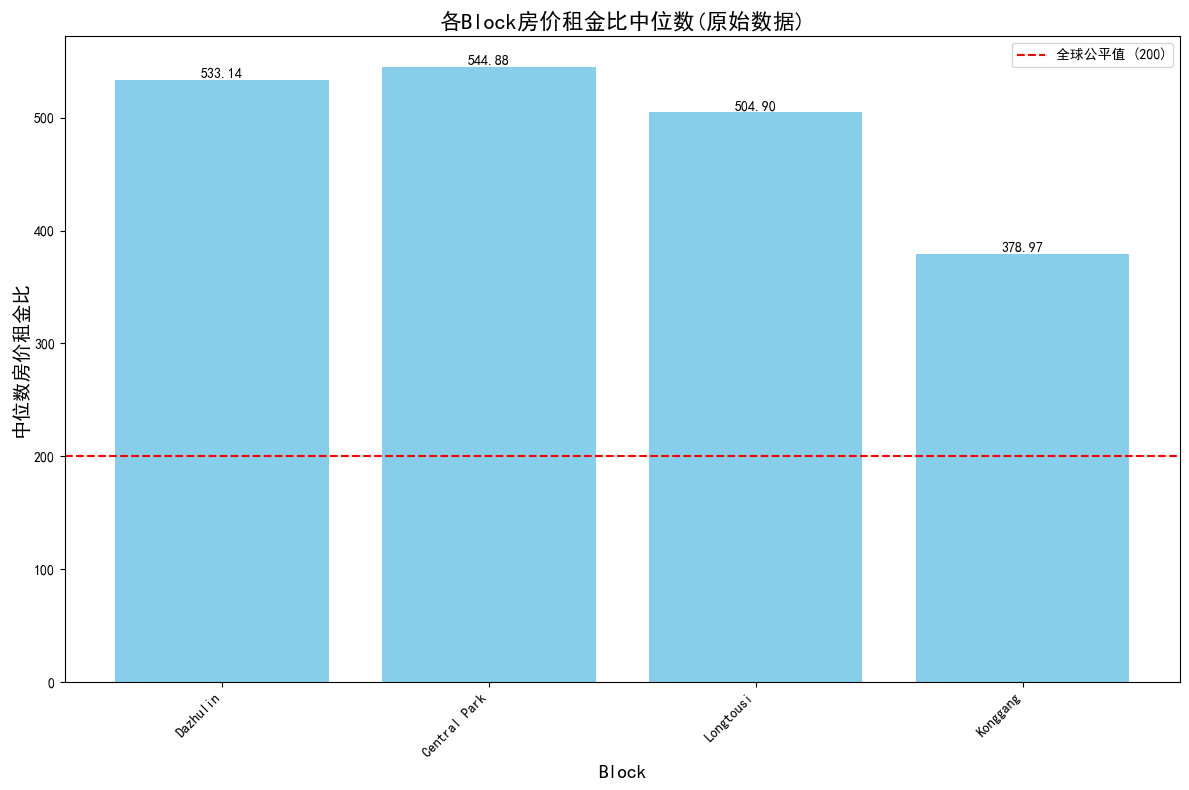

In [165]:
block_median_ratio_original = calculate_price_to_rent_ratio(block_medians_sale, block_medians_rent)

# 创建柱状图
plt.figure(figsize=(12, 8))
bars = plt.bar(block_median_ratio_original.index, block_median_ratio_original.values, color='skyblue')  

# 设置图表标题和标签
plt.title(f'各Block房价租金比中位数(原始数据)', fontsize=16)
plt.xlabel('Block', fontsize=14)
plt.ylabel('中位数房价租金比', fontsize=14)

plt.axhline(y=200, color='r', linestyle='--', label=f'全球公平值 (200)')
plt.legend()

# 旋转x轴标签以避免重叠
plt.xticks(rotation=45, ha='right')

# 添加数值标签
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, 
            f'{height:.2f}', ha='center', va='bottom')

# 调整布局
plt.tight_layout()

# 保存图表
chart_file = f'block_price_to_rent_ratio_median_original.png'
plt.savefig(chart_file)
print(f"房价租金比中位数柱状图(原始数据)已保存到: {chart_file}")

plt.show()

In [166]:
# 准备模型训练数据
X_sale, y_sale = prepare_data(sale_df, 'Price_Per_Area')
X_rent, y_rent = prepare_data(rental_df, 'Rent_Per_Area')

if X_sale is None or X_rent is None:
    print("无法继续，数据准备失败")

# 划分训练集和测试集
X_sale_train, X_sale_test, y_sale_train, y_sale_test = train_test_split(
    X_sale, y_sale, test_size=0.2, random_state=42
)

X_rent_train, X_rent_test, y_rent_train, y_rent_test = train_test_split(
    X_rent, y_rent, test_size=0.2, random_state=42
)

In [167]:
# 训练原始线性模型 (Model 1 和 Model 2)
price_model_linear = create_and_train_linear_model(X_sale_train, y_sale_train)
rent_model_linear = create_and_train_linear_model(X_rent_train, y_rent_train)

# 训练非线性模型 (Model 1+ 和 Model 2+)
price_model_nonlinear = create_and_train_nonlinear_interaction_model(X_sale_train, y_sale_train, degree=2)
rent_model_nonlinear = create_and_train_nonlinear_interaction_model(X_rent_train, y_rent_train, degree=2)


评估模型性能

Model 1 模型评估:
R² 分数: 0.4693
均方根误差 (RMSE): 3148.13

Model 2 模型评估:
R² 分数: 0.3591
均方根误差 (RMSE): 6.72

Model 1+ 模型评估:
R² 分数: 0.4955
均方根误差 (RMSE): 3069.47

Model 2+ 模型评估:
R² 分数: 0.3108
均方根误差 (RMSE): 6.96
R²分数比较图已保存到: r2_comparison_chart.png


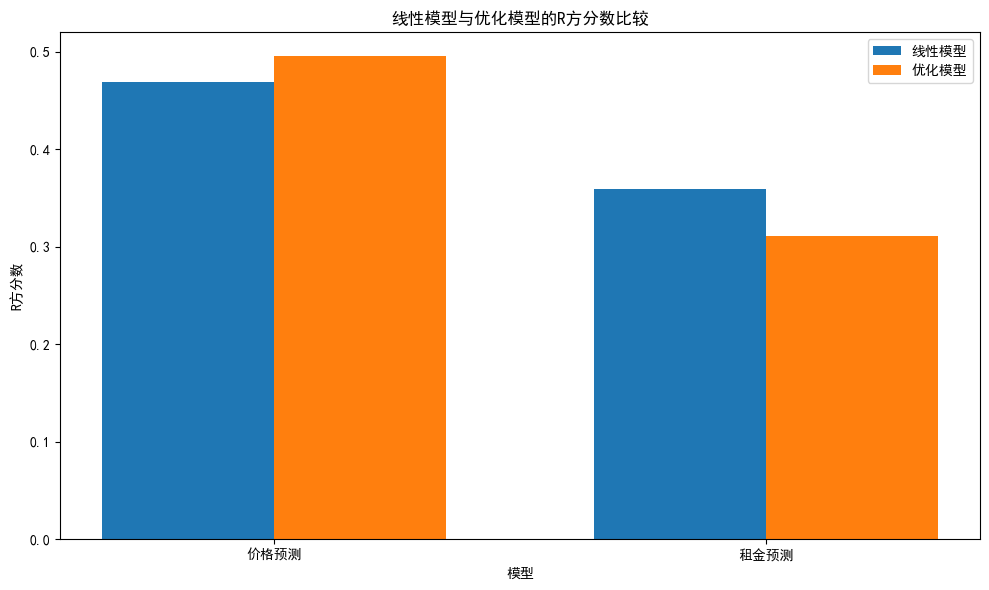


R²分数比较分析
模型 1+ 的R²分数(0.4955)高于模型 1 (0.4693)。
这可能是因为price与area之间存在非线性关系，通过添加非线性特征和交互项，模型能够捕捉到不同block之间更复杂的数据模式。
模型 2+ 的R²分数(0.3108)低于或等于模型 2 (0.3591)。
这可能是因为rent与area之间的关系基本上是线性的，或者添加的非线性特征导致了过拟合。


In [168]:
# 评估模型性能
print("\n" + "="*60)
print("评估模型性能")
print("="*60)

sale_test_pred_linear, sale_r2_linear = evaluate_model(price_model_linear, X_sale_test, y_sale_test, "Model 1")
rent_test_pred_linear, rent_r2_linear = evaluate_model(rent_model_linear, X_rent_test, y_rent_test, "Model 2")

sale_test_pred_nonlinear, sale_r2_nonlinear = evaluate_model(price_model_nonlinear, X_sale_test, y_sale_test, "Model 1+")
rent_test_pred_nonlinear, rent_r2_nonlinear = evaluate_model(rent_model_nonlinear, X_rent_test, y_rent_test, "Model 2+")

# 绘制R²分数比较图
plot_r2_comparison([sale_r2_linear, rent_r2_linear], [sale_r2_nonlinear, rent_r2_nonlinear], ['价格预测', '租金预测'])

# 比较R²分数并解释原因
print("\n" + "="*60)
print("R²分数比较分析")
print("="*60)

if sale_r2_nonlinear > sale_r2_linear:
    print(f"模型 1+ 的R²分数({sale_r2_nonlinear:.4f})高于模型 1 ({sale_r2_linear:.4f})。")
    print("这可能是因为price与area之间存在非线性关系，通过添加非线性特征和交互项，模型能够捕捉到不同block之间更复杂的数据模式。")
else:
    print(f"模型 1+ 的R²分数({sale_r2_nonlinear:.4f})低于或等于模型 1 ({sale_r2_linear:.4f})。")
    print("这可能是因为price与area之间的关系基本上是线性的，或者添加的非线性特征导致了过拟合。")

if rent_r2_nonlinear > rent_r2_linear:
    print(f"模型 2+ 的R²分数({rent_r2_nonlinear:.4f})高于模型 2 ({rent_r2_linear:.4f})。")
    print("这可能是因为rent与area之间存在非线性关系，通过添加非线性特征和交互项，模型能够捕捉到不同block之间更复杂的数据模式。")
else:
    print(f"模型 2+ 的R²分数({rent_r2_nonlinear:.4f})低于或等于模型 2 ({rent_r2_linear:.4f})。")
    print("这可能是因为rent与area之间的关系基本上是线性的，或者添加的非线性特征导致了过拟合。")



使用线性模型预测每个数据点的Price to Rent Ratio

为销售数据预测Price to Rent Ratio (使用线性模型):

销售数据前10个数据点的Price to Rent Ratio (线性模型):
数据点 1: 694.60
数据点 2: 894.01
数据点 3: 714.71
数据点 4: 552.70
数据点 5: 520.47
数据点 6: 574.50
数据点 7: 687.08
数据点 8: 829.95
数据点 9: 813.12
数据点 10: 633.60

销售数据Price to Rent Ratio 统计信息 (线性模型):
平均值: 636.58
中位数: 551.99
最小值: -4257.95
最大值: 52716.18

销售数据预测结果和Price to Rent Ratio已保存到: sale_data_with_predicted_ratio.csv

为租赁数据预测Price to Rent Ratio (使用线性模型):

租赁数据前10个数据点的Price to Rent Ratio (线性模型):
数据点 1: 480.71
数据点 2: 532.01
数据点 3: 552.58
数据点 4: 556.85
数据点 5: 561.18
数据点 6: 561.18
数据点 7: 565.56
数据点 8: 561.18
数据点 9: 528.05
数据点 10: 362.30

租赁数据Price to Rent Ratio 统计信息 (线性模型):
平均值: 521.07
中位数: 499.28
最小值: -1032.20
最大值: 30212.04

租赁数据预测结果和Price to Rent Ratio已保存到: rental_data_with_predicted_ratio.csv
房价租金比中位数柱状图 (线性模型)已保存到: block_price_to_rent_ratio_median_(线性模型).png


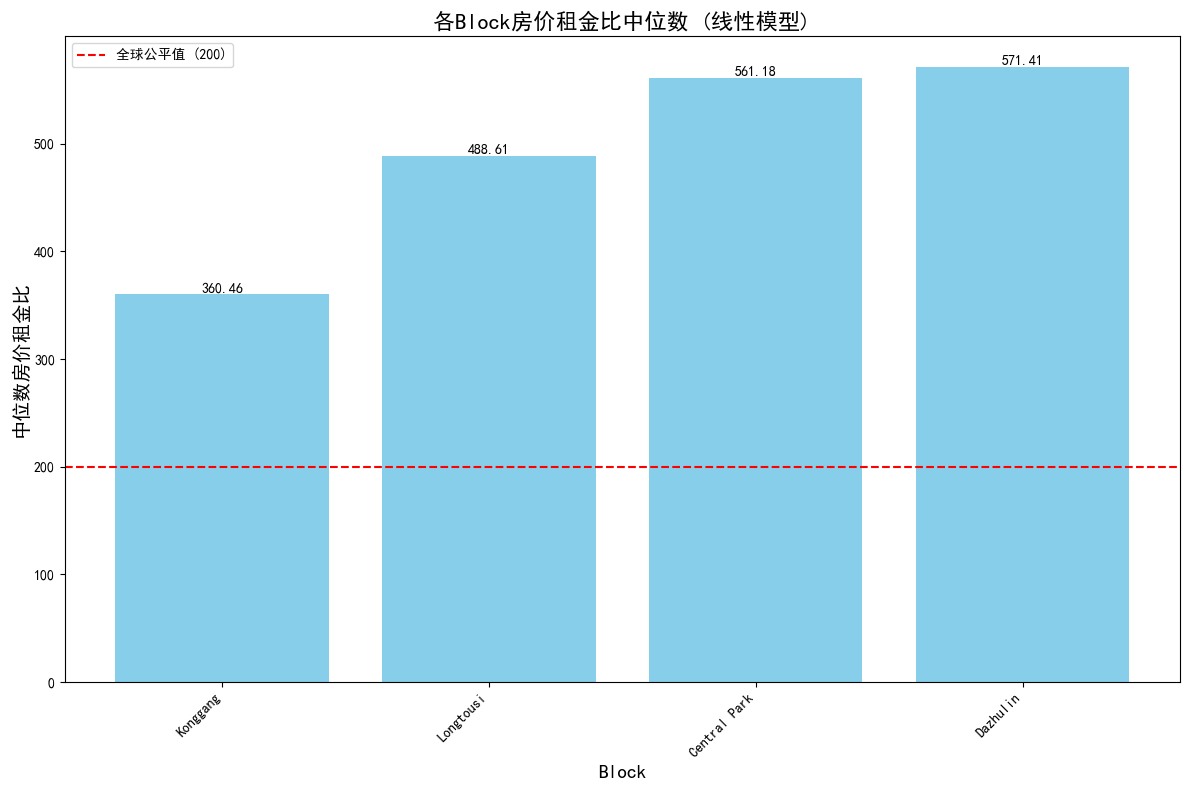

In [169]:
 # 使用线性模型预测Price to Rent Ratio (Model 1 和 Model 2)
print("\n" + "="*60)
print("使用线性模型预测每个数据点的Price to Rent Ratio")
print("="*60)

# 为销售数据的每个点预测价格
sale_predictions_linear = price_model_linear.predict(X_sale)

# 为租赁数据的每个点预测租金
rent_predictions_linear = rent_model_linear.predict(X_rent)

# 使用线性模型预测并保存销售数据的Price to Rent Ratio
print("\n为销售数据预测Price to Rent Ratio (使用线性模型):")
# 创建包含Area和Block的统一特征集
common_features_sale = X_sale.copy()
# 预测每个销售数据点对应的租金
predicted_rents_for_sale_linear = rent_model_linear.predict(common_features_sale)
# 计算Price to Rent Ratio
ptr_ratios_sale_linear = calculate_price_to_rent_ratio(sale_predictions_linear, predicted_rents_for_sale_linear)

if ptr_ratios_sale_linear is not None:
    # 显示前10个比率
    print("\n销售数据前10个数据点的Price to Rent Ratio (线性模型):")
    for i, ratio in enumerate(ptr_ratios_sale_linear[:10]):
        print(f"数据点 {i+1}: {ratio:.2f}")
    
    # 计算整体统计信息
    avg_ratio = np.mean(ptr_ratios_sale_linear)
    median_ratio = np.median(ptr_ratios_sale_linear)
    min_ratio = np.min(ptr_ratios_sale_linear)
    max_ratio = np.max(ptr_ratios_sale_linear)
    
    print(f"\n销售数据Price to Rent Ratio 统计信息 (线性模型):")
    print(f"平均值: {avg_ratio:.2f}")
    print(f"中位数: {median_ratio:.2f}")
    print(f"最小值: {min_ratio:.2f}")
    print(f"最大值: {max_ratio:.2f}")
    
    # 保存销售数据的结果
    sale_result_df_linear = pd.DataFrame({
        'Area': X_sale['Area'].values,
        'Block': X_sale['Block'].values,
        'Actual_Price_Per_Area': y_sale.values,
        'Predicted_Price_Per_Area': sale_predictions_linear,
        'Predicted_Rent_Per_Area': predicted_rents_for_sale_linear,
        'Price_to_Rent_Ratio': ptr_ratios_sale_linear
    })
    
    sale_result_file_linear = 'sale_data_with_predicted_ratio.csv'
    sale_result_df_linear.to_csv(sale_result_file_linear, index=False)
    print(f"\n销售数据预测结果和Price to Rent Ratio已保存到: {sale_result_file_linear}")

# 使用线性模型预测并保存租赁数据的Price to Rent Ratio
print("\n为租赁数据预测Price to Rent Ratio (使用线性模型):")
# 创建包含Area和Block的统一特征集
common_features_rent = X_rent.copy()
# 预测每个租赁数据点对应的价格
predicted_prices_for_rent_linear = price_model_linear.predict(common_features_rent)
# 计算Price to Rent Ratio
ptr_ratios_rent_linear = calculate_price_to_rent_ratio(predicted_prices_for_rent_linear, rent_predictions_linear)

if ptr_ratios_rent_linear is not None:
    # 显示前10个比率
    print("\n租赁数据前10个数据点的Price to Rent Ratio (线性模型):")
    for i, ratio in enumerate(ptr_ratios_rent_linear[:10]):
        print(f"数据点 {i+1}: {ratio:.2f}")
    
    # 计算整体统计信息
    avg_ratio = np.mean(ptr_ratios_rent_linear)
    median_ratio = np.median(ptr_ratios_rent_linear)
    min_ratio = np.min(ptr_ratios_rent_linear)
    max_ratio = np.max(ptr_ratios_rent_linear)
    
    print(f"\n租赁数据Price to Rent Ratio 统计信息 (线性模型):")
    print(f"平均值: {avg_ratio:.2f}")
    print(f"中位数: {median_ratio:.2f}")
    print(f"最小值: {min_ratio:.2f}")
    print(f"最大值: {max_ratio:.2f}")
    
    # 保存租赁数据的结果
    rent_result_df_linear = pd.DataFrame({
        'Area': X_rent['Area'].values,
        'Block': X_rent['Block'].values,
        'Actual_Rent_Per_Area': y_rent.values,
        'Predicted_Price_Per_Area': predicted_prices_for_rent_linear,
        'Predicted_Rent_Per_Area': rent_predictions_linear,
        'Price_to_Rent_Ratio': ptr_ratios_rent_linear
    })
    
    rent_result_file_linear = 'rental_data_with_predicted_ratio.csv'
    rent_result_df_linear.to_csv(rent_result_file_linear, index=False)
    print(f"\n租赁数据预测结果和Price to Rent Ratio已保存到: {rent_result_file_linear}")

# 合并销售数据和租赁数据的预测结果
merge_result_df_linear = pd.merge(sale_result_df_linear, rent_result_df_linear)

# 绘制每个block的预测房价租金比柱状图（线性模型）
plot_block_price_to_rent_ratio(merge_result_df_linear, 'Price_to_Rent_Ratio', " (线性模型)", global_fair_value=200)


使用优化模型预测每个数据点的Price to Rent Ratio

为销售数据预测Price to Rent Ratio (使用优化模型):

销售数据前10个数据点的Price to Rent Ratio (优化模型):
数据点 1: 723.69
数据点 2: 883.63
数据点 3: 742.86
数据点 4: 567.39
数据点 5: 526.87
数据点 6: 593.79
数据点 7: 716.34
数据点 8: 839.17
数据点 9: 826.47
数据点 10: 661.05

销售数据Price to Rent Ratio 统计信息 (优化模型):
平均值: 572.02
中位数: 526.80
最小值: -3586.62
最大值: 12357.94

销售数据预测结果和Price to Rent Ratio已保存到: sale_data_with_nonlinear_predicted_ratio.csv

为租赁数据预测Price to Rent Ratio (使用优化模型):

租赁数据前10个数据点的Price to Rent Ratio (优化模型):
数据点 1: 474.65
数据点 2: 541.57
数据点 3: 567.23
数据点 4: 572.47
数据点 5: 577.75
数据点 6: 577.75
数据点 7: 583.06
数据点 8: 577.75
数据点 9: 536.55
数据点 10: 309.62

租赁数据Price to Rent Ratio 统计信息 (优化模型):
平均值: 506.06
中位数: 506.23
最小值: 101.26
最大值: 1434.61

租赁数据预测结果和Price to Rent Ratio已保存到: rental_data_with_nonlinear_predicted_ratio.csv
房价租金比中位数柱状图 (优化模型)已保存到: block_price_to_rent_ratio_median_(优化模型).png


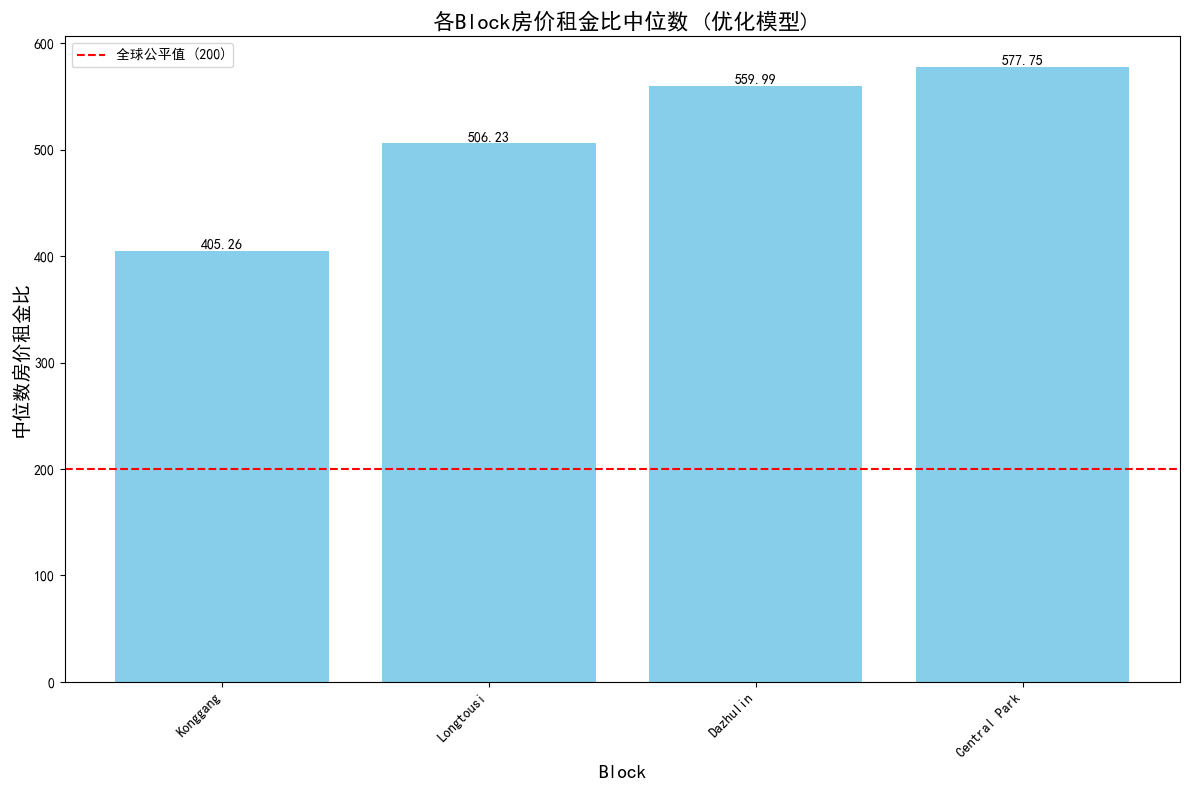

In [170]:
# 使用优化模型预测Price to Rent Ratio (Model 1+ 和 Model 2+)
print("\n" + "="*60)
print("使用优化模型预测每个数据点的Price to Rent Ratio")
print("="*60)

# 为销售数据的每个点预测价格（非线性）
sale_predictions_nonlinear = price_model_nonlinear.predict(X_sale)

# 为租赁数据的每个点预测租金（非线性）
rent_predictions_nonlinear = rent_model_nonlinear.predict(X_rent)

# 使用优化模型预测并保存销售数据的Price to Rent Ratio
print("\n为销售数据预测Price to Rent Ratio (使用优化模型):")
# 创建包含Area和Block的统一特征集
common_features_sale = X_sale.copy()
# 预测每个销售数据点对应的租金（非线性）
predicted_rents_for_sale_nonlinear = rent_model_nonlinear.predict(common_features_sale)
# 计算Price to Rent Ratio（非线性）
ptr_ratios_sale_nonlinear = calculate_price_to_rent_ratio(sale_predictions_nonlinear, predicted_rents_for_sale_nonlinear)

if ptr_ratios_sale_nonlinear is not None:
    # 显示前10个比率
    print("\n销售数据前10个数据点的Price to Rent Ratio (优化模型):")
    for i, ratio in enumerate(ptr_ratios_sale_nonlinear[:10]):
        print(f"数据点 {i+1}: {ratio:.2f}")
    
    # 计算整体统计信息
    avg_ratio = np.mean(ptr_ratios_sale_nonlinear)
    median_ratio = np.median(ptr_ratios_sale_nonlinear)
    min_ratio = np.min(ptr_ratios_sale_nonlinear)
    max_ratio = np.max(ptr_ratios_sale_nonlinear)
    
    print(f"\n销售数据Price to Rent Ratio 统计信息 (优化模型):")
    print(f"平均值: {avg_ratio:.2f}")
    print(f"中位数: {median_ratio:.2f}")
    print(f"最小值: {min_ratio:.2f}")
    print(f"最大值: {max_ratio:.2f}")
    
    # 保存销售数据的结果
    sale_result_df_nonlinear = pd.DataFrame({
        'Area': X_sale['Area'].values,
        'Block': X_sale['Block'].values,
        'Actual_Price_Per_Area': y_sale.values,
        'Predicted_Price_Per_Area_Linear': sale_predictions_linear,
        'Predicted_Price_Per_Area_Nonlinear': sale_predictions_nonlinear,
        'Predicted_Rent_Per_Area_Linear': predicted_rents_for_sale_linear,
        'Predicted_Rent_Per_Area_Nonlinear': predicted_rents_for_sale_nonlinear,
        'Price_to_Rent_Ratio_Linear': ptr_ratios_sale_linear,
        'Price_to_Rent_Ratio_Nonlinear': ptr_ratios_sale_nonlinear
    })
    
    sale_result_file_nonlinear = 'sale_data_with_nonlinear_predicted_ratio.csv'
    sale_result_df_nonlinear.to_csv(sale_result_file_nonlinear, index=False)
    print(f"\n销售数据预测结果和Price to Rent Ratio已保存到: {sale_result_file_nonlinear}")

# 使用优化模型预测并保存租赁数据的Price to Rent Ratio
print("\n为租赁数据预测Price to Rent Ratio (使用优化模型):")
# 创建包含Area和Block的统一特征集
common_features_rent = X_rent.copy()
# 预测每个租赁数据点对应的价格（非线性）
predicted_prices_for_rent_nonlinear = price_model_nonlinear.predict(common_features_rent)
# 计算Price to Rent Ratio（非线性）
ptr_ratios_rent_nonlinear = calculate_price_to_rent_ratio(predicted_prices_for_rent_nonlinear, rent_predictions_nonlinear)

if ptr_ratios_rent_nonlinear is not None:
    # 显示前10个比率
    print("\n租赁数据前10个数据点的Price to Rent Ratio (优化模型):")
    for i, ratio in enumerate(ptr_ratios_rent_nonlinear[:10]):
        print(f"数据点 {i+1}: {ratio:.2f}")
    
    # 计算整体统计信息
    avg_ratio = np.mean(ptr_ratios_rent_nonlinear)
    median_ratio = np.median(ptr_ratios_rent_nonlinear)
    min_ratio = np.min(ptr_ratios_rent_nonlinear)
    max_ratio = np.max(ptr_ratios_rent_nonlinear)
    
    print(f"\n租赁数据Price to Rent Ratio 统计信息 (优化模型):")
    print(f"平均值: {avg_ratio:.2f}")
    print(f"中位数: {median_ratio:.2f}")
    print(f"最小值: {min_ratio:.2f}")
    print(f"最大值: {max_ratio:.2f}")
    
    # 保存租赁数据的结果
    rent_result_df_nonlinear = pd.DataFrame({
        'Area': X_rent['Area'].values,
        'Block': X_rent['Block'].values,
        'Actual_Rent_Per_Area': y_rent.values,
        'Predicted_Price_Per_Area_Linear': predicted_prices_for_rent_linear,
        'Predicted_Price_Per_Area_Nonlinear': predicted_prices_for_rent_nonlinear,
        'Predicted_Rent_Per_Area_Linear': rent_predictions_linear,
        'Predicted_Rent_Per_Area_Nonlinear': rent_predictions_nonlinear,
        'Price_to_Rent_Ratio_Linear': ptr_ratios_rent_linear,
        'Price_to_Rent_Ratio_Nonlinear': ptr_ratios_rent_nonlinear
    })
    
    rent_result_file_nonlinear = 'rental_data_with_nonlinear_predicted_ratio.csv'
    rent_result_df_nonlinear.to_csv(rent_result_file_nonlinear, index=False)
    print(f"\n租赁数据预测结果和Price to Rent Ratio已保存到: {rent_result_file_nonlinear}")


# 合并销售数据和租赁数据的预测结果
merge_result_df_nonlinear = pd.merge(sale_result_df_nonlinear, rent_result_df_nonlinear)

# 绘制带全球公平值参考线的柱状图 - Figure A
plot_block_price_to_rent_ratio(merge_result_df_nonlinear, 'Price_to_Rent_Ratio_Nonlinear', " (优化模型)", global_fair_value=200)
